In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.spatial.transform import Rotation as r
from scipy.optimize import curve_fit

In [2]:
def sph2cart(phi, theta, T):
    """ Convert from spherical/polar (phi, thetha) to cartesian
    coordinates.

    Parameters
    ----------
    phi : int or float between 0 and 90
        angle respect to the c-axis
    theta : int or float between 0 and 360
        angle respect to the a-axis
    T : int or float
        the magnitud of the vector (rho) in polar coordinates

    Returns
    -------
    numpy ndarrays (1d)
        three numpy 1d arrays with the x, y, and z coordinates
    """
    
    x = T * np.sin(phi) * np.cos(theta)
    y = T * np.sin(phi) * np.sin(theta)
    z = T * np.cos(phi)
    
    return x, y, z


def Tvalues(trans, phi, theta):
    """ Calculates the transmission value for any direction in polar
    coordinates using the equation (5) of Asimov et al. (2006).

    Parameters
    ----------
    trans : a tuple of size 3
        tuple containeing the transmission values along a-axis (Ta),
        b-axis (Tb), and c-axis (Tc). -> (Ta, Tb, Tc)
    phi : int or float between 0 and 90
        angle respect to the c-axis
    theta : int or float between 0 and 360
        angle respect to the a-axis

    Returns
    -------
    numpy array
        the calculated T values for any given orientation
    """

    # extract Tx values
    Ta, Tb, Tc = trans
    
    return Ta * np.cos(theta)**2 * np.sin(phi)**2 + \
           Tb * np.sin(theta)**2 * np.sin(phi)**2 + \
           Tc * np.cos(phi)**2


> **Caution note**: if we create a uniform dataset for theta and phi, the dataset generated will not be uniformly distributed because of the polar coordinates.
> See https://mathworld.wolfram.com/SpherePointPicking.html or  
> https://www.jasondavies.com/maps/random-points/

(Text(0.5, 0, '$x$'), Text(0.5, 0.5, '$y$'), Text(0.5, 0, '$z$'))

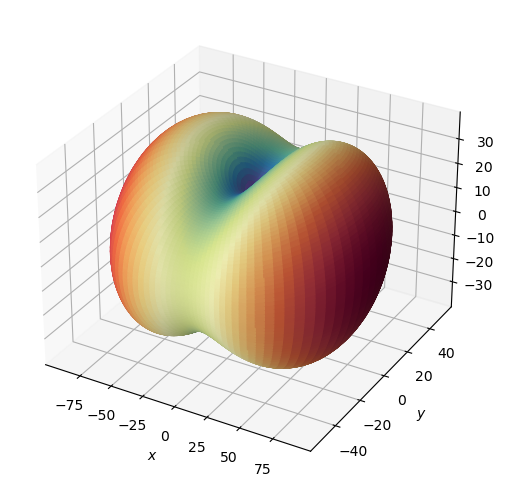

In [3]:
# generate spherical/polar coordinates
theta = np.linspace(0, 2*np.pi, 100)
phi = np.arccos(1 - 2 * np.linspace(0, 1, 100))  # in this case np.linspace goes from 0 to 1 (not pi)!
phi, theta = np.meshgrid(phi, theta)
# NOTE: Test this later as https://www.jasondavies.com/maps/random-points/ indicate: phi = arcos(2x - 1)

# estimate T values
T = Tvalues(trans=(90, 50, 20), phi=phi, theta=theta)

# convert from spherical to cartesian coordinates
x, y, z = sph2cart(phi, theta, T)

# normalize colors for T values to max and min values
Tmax, Tmin = T.max(), T.min()
Tcolors = (T - Tmin) / (Tmax - Tmin)

# make figure
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, constrained_layout=True)

ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=cm.Spectral_r(Tcolors))
ax.set_xlabel(r'$x$'), ax.set_ylabel(r'$y$'), ax.set_zlabel(r'$z$')

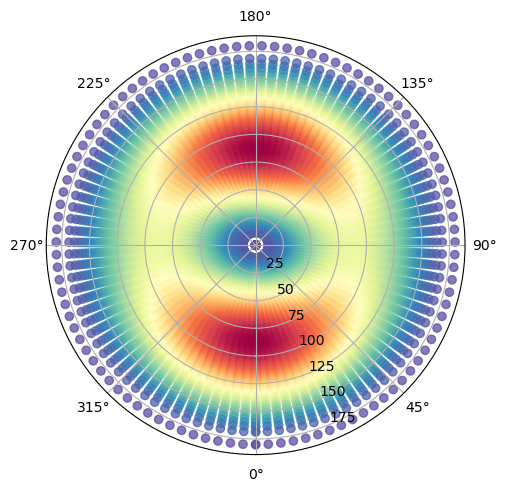

In [4]:
# make polar scatter figure, colors represent T values
# make figure
fig2, ax = plt.subplots(subplot_kw={"projection": "polar"}, constrained_layout=True)

# locate theta origin south as in the figure 1 of Asimov et al. (2006)
ax.set_theta_zero_location('S')

# plot the data (for phi I converted radians to degrees)
_ = ax.scatter(theta, np.rad2deg(phi), c=T, cmap='Spectral_r', alpha=0.75)

In [5]:
def rotate(coordinates, euler_ang):
    """_summary_

    Parameters
    ----------
    coordinates : tuple of size 3
        a tuple containing the cartesian coordinates of this form:
        (x, y, z). variables x, y and z can be scalars or arrays.
    euler_ang : tuple of size 3
        a tuple containing the three euler angles in degrees
        using Bunge convention -> (z, x, z)

    Returns
    -------
    three numpy arrays containing the x, y, z coordinates respectively
    
    Example
    -------
    x, y, z = rotate(coordinates=(x, y, z), euler_ang=(30, 0, 40))
    """
    # create a ndarray to vectorize the rotation operation
    coordinates = np.dstack(coordinates)

    # define a rotation in euler space (Bunge) for intrinsic rotations
    rotation = r.from_euler('zxz', [euler_ang[0], euler_ang[1], euler_ang[2]], degrees=True)

    # apply rotation
    new_coordinates = coordinates @ rotation.as_matrix().T

    return new_coordinates[:,:,0], new_coordinates[:,:,1], new_coordinates[:,:,2]

In [6]:
rot_x, rot_y, rot_z = rotate(coordinates=(x, y, z), euler_ang=(30, 45, 60))

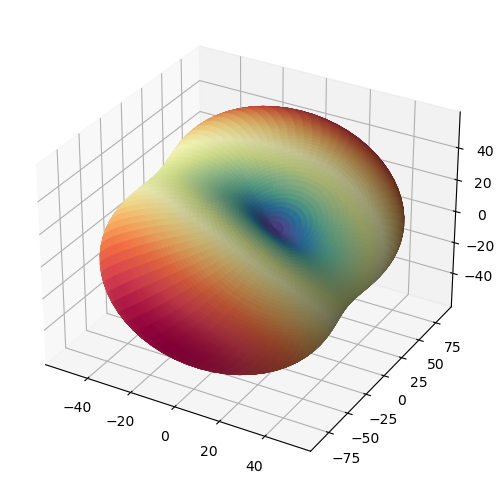

In [7]:
# check making a plot
fig2, ax = plt.subplots(subplot_kw={"projection": "3d"}, constrained_layout=True)
ax.plot_surface(rot_x, rot_y, rot_z, rstride=1, cstride=1, facecolors=cm.Spectral_r(Tcolors))

The transmission envelope has an orthorhombic symmetry. In the Bunge convention and for intrinsic rotations, the minimum range of Euler angles to define any orientation of an orthorhombic summetry (space group Pbnm) are:

$0^{\circ} \leq \varphi_{1} < 90^{\circ}$    
$0^{\circ} \leq \varphi_{2} < 180^{\circ}$  
$0^{\circ} \leq \varphi_{3} < 90^{\circ}$  

> Intrinsic rotations means that these Euler angles describe the rotations that are needed to align the crystal/object with a reference frame where the symmetry elements of the crystal are in a fixed position.

 Let's check this:

In [8]:
# rotations around phi 1
rotation_0 = rotate(coordinates=(x, y, z), euler_ang=(45, 0, 0))
rotation_1 = rotate(coordinates=(x, y, z), euler_ang=(90, 0, 0))
# rotations around phi 2
rotation_2 = rotate(coordinates=(x, y, z), euler_ang=(0, 45, 0))
rotation_3 = rotate(coordinates=(x, y, z), euler_ang=(0, 90, 0))
rotation_4 = rotate(coordinates=(x, y, z), euler_ang=(0, 180, 0))
# combined rotations
rotation_5 = rotate(coordinates=(x, y, z), euler_ang=(90, 90, 0))
rotation_6 = rotate(coordinates=(x, y, z), euler_ang=(0, 90, 90))
rotation_7 = rotate(coordinates=(x, y, z), euler_ang=(90, 180, 90))

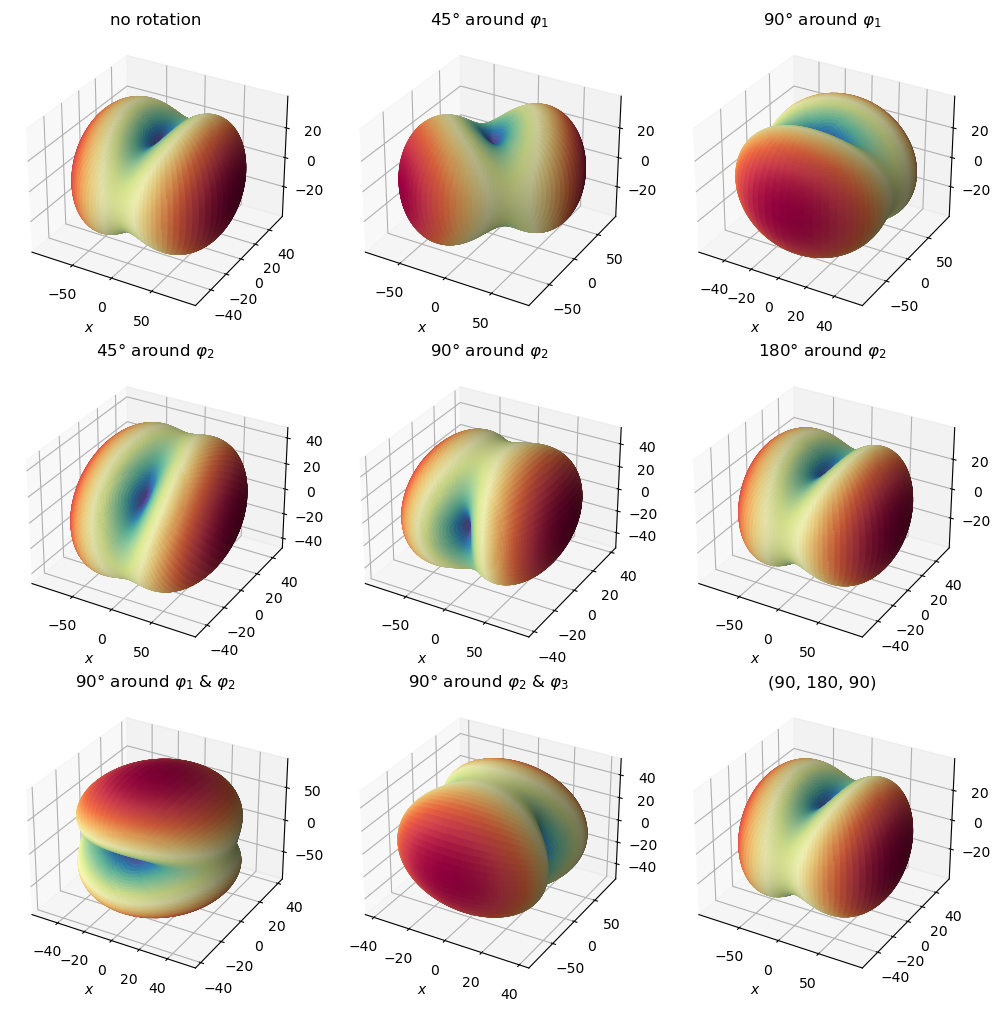

In [9]:
# make plot
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(10, 10), subplot_kw={"projection": "3d"}, constrained_layout=True)

# first row: rotations around phi 1
axes[0,0].plot_surface(x, y, z, rstride=1, cstride=1, facecolors=cm.Spectral_r(Tcolors))
axes[0,0].set_xlabel(r'$x$')
axes[0,0].set_title('no rotation')

axes[0,1].plot_surface(rotation_0[0], rotation_0[1], rotation_0[2], rstride=1, cstride=1, facecolors=cm.Spectral_r(Tcolors))
axes[0,1].set_xlabel(r'$x$')
axes[0,1].set_title(r'45° around $\varphi_{1}$')

axes[0,2].plot_surface(rotation_1[0], rotation_1[1], rotation_1[2], rstride=1, cstride=1, facecolors=cm.Spectral_r(Tcolors))
axes[0,2].set_xlabel(r'$x$'), ax.set_ylabel(r'$y$'), ax.set_zlabel(r'$z$')
axes[0,2].set_title(r'90° around $\varphi_{1}$')

# second row: rotations around phi 2
axes[1,0].plot_surface(rotation_2[0], rotation_2[1], rotation_2[2], rstride=1, cstride=1, facecolors=cm.Spectral_r(Tcolors))
axes[1,0].set_xlabel(r'$x$')
axes[1,0].set_title(r'45° around $\varphi_{2}$')

axes[1,1].plot_surface(rotation_3[0], rotation_3[1], rotation_3[2], rstride=1, cstride=1, facecolors=cm.Spectral_r(Tcolors))
axes[1,1].set_xlabel(r'$x$')
axes[1,1].set_title(r'90° around $\varphi_{2}$')

axes[1,2].plot_surface(rotation_4[0], rotation_4[1], rotation_4[2], rstride=1, cstride=1, facecolors=cm.Spectral_r(Tcolors))
axes[1,2].set_xlabel(r'$x$')
axes[1,2].set_title(r'180° around $\varphi_{2}$')

# third row: combined rotations
axes[2,0].plot_surface(rotation_5[0], rotation_5[1], rotation_5[2], rstride=1, cstride=1, facecolors=cm.Spectral_r(Tcolors))
axes[2,0].set_xlabel(r'$x$')
axes[2,0].set_title(r'90° around $\varphi_{1}$ & $\varphi_{2}$')

axes[2,1].plot_surface(rotation_6[0], rotation_6[1], rotation_6[2], rstride=1, cstride=1, facecolors=cm.Spectral_r(Tcolors))
axes[2,1].set_xlabel(r'$x$')
axes[2,1].set_title(r'90° around $\varphi_{2}$ & $\varphi_{3}$')

axes[2,2].plot_surface(rotation_7[0], rotation_7[1], rotation_7[2], rstride=1, cstride=1, facecolors=cm.Spectral_r(Tcolors))
axes[2,2].set_xlabel(r'$x$')
_ = axes[2,2].set_title(r'(90, 180, 90)')

# Generate a toy dataset to test

In [10]:
# generate random spherical/polar coordinates (just 5x5=25)
np.random.seed(218)  # this is just for reproducibility (generates random number based on seed. Seed can be any number), comment if you want to generate different toy datasets
phi = np.arccos(1 - 2 * np.random.uniform(low=0, high=1, size=5))
theta = np.random.uniform(low=0, high=2*np.pi, size=5)
phi, theta = np.meshgrid(phi, theta)

# estimate T values
T = Tvalues(trans=(90, 50, 20), phi=phi, theta=theta)

# convert from spherical to cartesian coordinates
x, y, z = sph2cart(phi, theta, T)

len(x), len(y), len(z), len(T), len(phi)

(5, 5, 5, 5, 5)

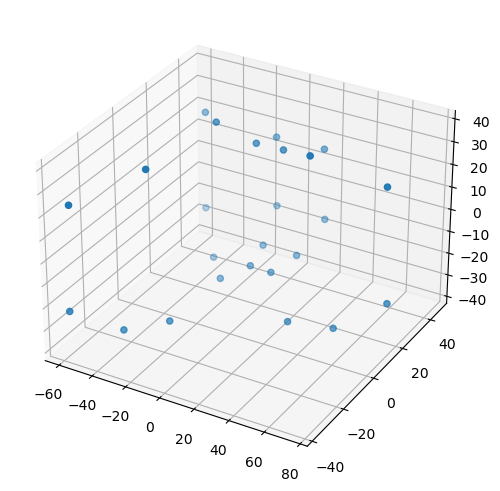

In [11]:
# check making a plot
fig3, ax = plt.subplots(subplot_kw={"projection": "3d"}, constrained_layout=True)
ax.scatter(x, y, z)

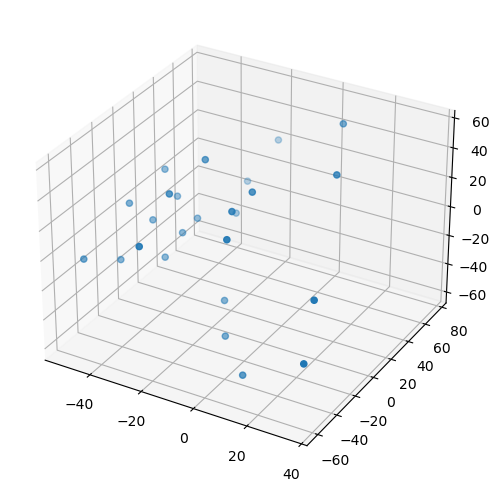

In [12]:
rot_x, rot_y, rot_z = rotate(coordinates=(x, y, z), euler_ang=(30, 45, 60))

# check making a plot
fig4, ax = plt.subplots(subplot_kw={"projection": "3d"}, constrained_layout=True)
ax.scatter(rot_x, rot_y, rot_z)

# Fitting test using the curve_fit procedure

The routine ``curve_fit`` works as follow

- the first argument is the function to minimize
- the second argument is the independ data (for convenience the coordinates of the points for when euler angles are (0,0,0))
- the second argument is the dependent data (the transformed/rotated coordinates)
- the fourth argument is the initial guess of the different parameters

TODO

$$
y = Rx
$$

where
- $y$ is the $(x,y,z)$ coordinates of the rotated data (what we measure),
- $x$ is the $(x,y,z)$ coordinates of the unrotated data, and
- $R$ the matrix rotation estimated from the Euler angles.

In [13]:
def func(ref_coordinates, a, b, c):
    """_summary_

    Parameters
    ----------
    ref_coordinates : array-like
        a numpy 1d array containing the Cartesian coordinates
        x, y and z (in that order) of the points.
    a : _type_
        _description_
    b : _type_
        _description_
    c : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """

    # check that the array is a multiple of 3
    if ref_coordinates.size % 3 != 0:
        raise ValueError("ref_coordinates must be multiples of 3!")

    # define a rotation in euler space (Bunge) and intrinsic rotations
    rotation = r.from_euler('zxz', [a, b, c], degrees=True)

    # reshape (x, y, z) coordinates to apply rotation
    # it must have a shape of (1, n, 3)
    n = int(ref_coordinates.size / 3)
    coordinates = ref_coordinates.reshape(1, n, 3)

    # apply rotation
    guess_coordinates = coordinates @ rotation.as_matrix().T

    return guess_coordinates.flatten()

In [14]:
# this will not be necessary once the refactoring is done
ref_coordinates = np.dstack((x, y, z))
rot_coordinates = np.dstack((rot_x, rot_y, rot_z))

In [15]:
# test curve_fit
popt, pcov = curve_fit(func,
                       xdata=ref_coordinates.flatten(),      # independent data (array flattened)
                       ydata=rot_coordinates.flatten(),      # dependent data (array flattened)
                       p0=(45, 90, 45),                      # initial guess for euler angles (it didn't work when using (0,0,0))
                       bounds=((0, 0, 0), (90, 180, 90)))    # minimum bounds in the orthorhombic symmetry

In [16]:
# plot the solution
popt

array([30., 45., 60.])

Voila, the exact result so it works.

> In previous attempts the procedure failed because the ``curve_fit()``, and thus ``least_squares()``, expect that the function returns a 1-d array, i.e. of shape ``(n,)``. We need to flatten/ravel de n-d arrays that represents the indepent and dependent data into 1-d arrays to make it work.

In [17]:
# standard deviation
np.sqrt(np.diag(pcov))

array([7.10808003e-15, 5.15238782e-15, 7.40016288e-15])

## Tests using exact solutions (no errors in the datapoints)

### First test: same solution different datapoints (sample size fixed to 10; number of test 15)

In [18]:
for i in range(15):
    # generate random spherical/polar coordinates
    phi = np.arccos(1 - 2 * np.random.uniform(low=0, high=1, size=10))
    theta = np.random.uniform(low=0, high=2*np.pi, size=10)

    # estimate T values
    T = Tvalues(trans=(90, 50, 20), phi=phi, theta=theta)

    # convert from spherical to cartesian coordinates
    x, y, z = sph2cart(phi, theta, T)

    # get the coordinates of the rotated points
    rot_x, rot_y, rot_z = rotate(coordinates=(x, y, z), euler_ang=(15, 42, 40))
    
    # stack coordinates
    ref_coordinates = np.dstack((x, y, z))
    rot_coordinates = np.dstack((rot_x, rot_y, rot_z))

    # test curve_fit
    popt, pcov = curve_fit(func,
                           xdata=ref_coordinates.flatten(),      # independent data (array flattened)
                           ydata=rot_coordinates.flatten(),      # dependent data (array flattened)
                           p0=(45, 90, 45),                      # initial guess for euler angles
                           bounds=((0, 0, 0), (90, 180, 90)))    # bounds
    
    print(popt)
    #print(np.sqrt(np.diag(pcov)))
    #print('')

print('DONE')


[15. 42. 40.]
[15. 42. 40.]
[15. 42. 40.]
[15. 42. 40.]
[15. 42. 40.]
[15. 42. 40.]
[15. 42. 40.]
[15. 42. 40.]
[15. 42. 40.]
[15. 42. 40.]
[15. 42. 40.]
[15. 42. 40.]
[15. 42. 40.]
[15. 42. 40.]
[15. 42. 40.]
DONE


### Same solution (euler angles) but different sample size

In [19]:
size = [10, 9, 8, 7, 6, 5, 4, 3, 2]

for i in range(len(size)):
    # generate random spherical/polar coordinates
    phi = np.arccos(1 - 2 * np.random.uniform(low=0, high=1, size=size[i]))
    theta = np.random.uniform(low=0, high=2*np.pi, size=size[i])

    # estimate T values
    T = Tvalues(trans=(90, 50, 20), phi=phi, theta=theta)

    # convert from spherical to cartesian coordinates (independent data)
    x, y, z = sph2cart(phi, theta, T)

    # get the coordinates of the rotated points (dependent data)
    rot_x, rot_y, rot_z = rotate(coordinates=(x, y, z), euler_ang=(15, 42, 40))
    
    # stack coordinates
    ref_coordinates = np.dstack((x, y, z))
    rot_coordinates = np.dstack((rot_x, rot_y, rot_z))

    # test curve_fit
    popt, pcov = curve_fit(func,
                           xdata=ref_coordinates.flatten(), 
                           ydata=rot_coordinates.flatten(),   
                           p0=(45, 90, 45),
                           bounds=((0, 0, 0), (90, 180, 90)))
    
    print(f'n = {size[i]}; {popt}')
    #print(np.sqrt(np.diag(pcov)))
    #print('')

print('DONE')

n = 10; [15. 42. 40.]
n = 9; [15. 42. 40.]
n = 8; [15. 42. 40.]
n = 7; [15. 42. 40.]
n = 6; [15. 42. 40.]
n = 5; [15. 42. 40.]
n = 4; [15. 42. 40.]
n = 3; [15. 42. 40.]
n = 2; [15. 42. 40.]
DONE


## Different solutions (random euler angles) same sample size (n=5) 

In [20]:
for i in range(100):
    # generate random spherical/polar coordinates
    phi = np.arccos(1 - 2 * np.random.uniform(low=0, high=1, size=5))
    theta = np.random.uniform(low=0, high=2*np.pi, size=5)

    # estimate T values
    T = Tvalues(trans=(90, 50, 20), phi=phi, theta=theta)

    # convert from spherical to cartesian coordinates
    x, y, z = sph2cart(phi, theta, T)

    # generate random euler angle values
    a = np.random.randint(low=0, high=90)
    b = np.random.randint(low=0, high=180)
    c = np.random.randint(low=0, high=90)

    # get the coordinates of the rotated points
    rot_x, rot_y, rot_z = rotate(coordinates=(x, y, z), euler_ang=(a, b, c))
    
    # stack coordinates
    ref_coordinates = np.dstack((x, y, z))
    rot_coordinates = np.dstack((rot_x, rot_y, rot_z))

    # test curve_fit
    popt, pcov = curve_fit(func,
                           xdata=ref_coordinates.flatten(),      # independent data (array flattened)
                           ydata=rot_coordinates.flatten(),      # dependent data (array flattened)
                           p0=(45, 90, 45),                      # initial guess for euler angles
                           bounds=((0, 0, 0), (90, 180, 90)))
    
    print(f"Real = ({a}, {b}, {c}); estimated = {popt}")
    #print(np.sqrt(np.diag(pcov)))
    #print('')

print('DONE')

Real = (4, 173, 21); estimated = [  4. 173.  21.]
Real = (2, 61, 86); estimated = [ 2. 61. 86.]
Real = (36, 173, 60); estimated = [ 36. 173.  60.]
Real = (39, 154, 59); estimated = [ 39. 154.  59.]
Real = (74, 140, 55); estimated = [ 74. 140.  55.]
Real = (78, 166, 41); estimated = [ 78. 166.  41.]
Real = (87, 79, 23); estimated = [87. 79. 23.]
Real = (40, 90, 2); estimated = [40. 90.  2.]
Real = (73, 179, 32); estimated = [ 73. 179.  32.]
Real = (87, 83, 23); estimated = [87. 83. 23.]
Real = (26, 122, 57); estimated = [ 26. 122.  57.]
Real = (46, 27, 50); estimated = [46. 27. 50.]
Real = (32, 72, 24); estimated = [32. 72. 24.]
Real = (16, 177, 2); estimated = [ 16. 177.   2.]
Real = (15, 123, 3); estimated = [ 15. 123.   3.]
Real = (26, 133, 85); estimated = [ 26. 133.  85.]
Real = (13, 75, 50); estimated = [13. 75. 50.]
Real = (82, 32, 77); estimated = [82. 32. 77.]
Real = (31, 130, 20); estimated = [ 31. 130.  20.]
Real = (57, 105, 77); estimated = [ 57. 105.  77.]
Real = (73, 37, 8

## Test limit cases: euler angles = (0,0,0) & (90, 180, 90) (n=5, no errors in the datapoints)

Actually both limit cases represent the same crystal orientation

In [21]:
for i in range(10):
    # generate random spherical/polar coordinates
    phi = np.arccos(1 - 2 * np.random.uniform(low=0, high=1, size=10))
    theta = np.random.uniform(low=0, high=2*np.pi, size=10)

    # estimate T values
    T = Tvalues(trans=(90, 50, 20), phi=phi, theta=theta)

    # convert from spherical to cartesian coordinates
    x, y, z = sph2cart(phi, theta, T)

    # get the coordinates of the rotated points
    rot_x, rot_y, rot_z = rotate(coordinates=(x, y, z), euler_ang=(0, 0, 0))
    
    # stack coordinates
    ref_coordinates = np.dstack((x, y, z))
    rot_coordinates = np.dstack((rot_x, rot_y, rot_z))

    # test curve_fit
    popt, pcov = curve_fit(func,
                           xdata=ref_coordinates.flatten(),      # independent data (array flattened)
                           ydata=rot_coordinates.flatten(),      # dependent data (array flattened)
                           p0=(45, 90, 45),                      # initial guess for euler angles
                           bounds=((0, 0, 0), (90, 180, 90)))
    
    print(np.around(popt, decimals=1))
    #print(np.sqrt(np.diag(pcov)))
    #print('')

print('DONE')

[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
DONE


For the (0, 0, 0) limit case it holds.

In [22]:
for i in range(10):
    # generate random spherical/polar coordinates
    phi = np.arccos(1 - 2 * np.random.uniform(low=0, high=1, size=5))
    theta = np.random.uniform(low=0, high=2*np.pi, size=5)

    # estimate T values
    T = Tvalues(trans=(90, 50, 20), phi=phi, theta=theta)

    # convert from spherical to cartesian coordinates
    x, y, z = sph2cart(phi, theta, T)

    # get the coordinates of the rotated points
    rot_x, rot_y, rot_z = rotate(coordinates=(x, y, z), euler_ang=(90, 180, 90))
    
    # stack coordinates
    ref_coordinates = np.dstack((x, y, z))
    rot_coordinates = np.dstack((rot_x, rot_y, rot_z))

    # test curve_fit
    popt, pcov = curve_fit(func,
                           xdata=ref_coordinates.flatten(),      # independent data (array flattened)
                           ydata=rot_coordinates.flatten(),      # dependent data (array flattened)
                           p0=(45, 90, 45),                      # initial guess for euler angles
                           bounds=((0, 0, 0), (90, 180, 90)))
    
    print(np.around(popt, decimals=1))
    #print(np.sqrt(np.diag(pcov)))
    #print('')

print('DONE')

[ 11.7 180.   11.7]
[  4.4 180.    4.4]
[ 86.6 180.   86.6]
[ 26.9 180.   26.9]
[ 89.3 180.   89.3]
[  4.4 180.    4.4]
[ 29.2 180.   29.2]
[ 30.4 180.   30.4]
[  3.3 180.    3.3]
[ 24.8 180.   24.8]
DONE


For the (90, 180, 90) limit case it fails! Gimbal lock?

Let's try with a close value to the limit case:

In [23]:
for i in range(10):
    # generate random spherical/polar coordinates
    phi = np.arccos(1 - 2 * np.random.uniform(low=0, high=1, size=5))
    theta = np.random.uniform(low=0, high=2*np.pi, size=5)

    # estimate T values
    T = Tvalues(trans=(90, 50, 20), phi=phi, theta=theta)

    # convert from spherical to cartesian coordinates
    x, y, z = sph2cart(phi, theta, T)

    # get the coordinates of the rotated points
    rot_x, rot_y, rot_z = rotate(coordinates=(x, y, z), euler_ang=(89.9, 179.9, 89.9))
    
    # stack coordinates
    ref_coordinates = np.dstack((x, y, z))
    rot_coordinates = np.dstack((rot_x, rot_y, rot_z))

    # test curve_fit
    popt, pcov = curve_fit(func,
                           xdata=ref_coordinates.flatten(),      # independent data (array flattened)
                           ydata=rot_coordinates.flatten(),      # dependent data (array flattened)
                           p0=(45, 90, 45),                      # initial guess for euler angles
                           bounds=((0, 0, 0), (90, 180, 90)))
    
    print(np.around(popt, decimals=1))
    #print(np.sqrt(np.diag(pcov)))
    #print('')

print('DONE')

[ 89.9 179.9  89.9]
[ 89.9 179.9  89.9]
[ 89.9 179.9  89.9]
[ 89.9 179.9  89.9]
[ 89.9 179.9  89.9]
[ 89.9 179.9  89.9]
[ 89.9 179.9  89.9]
[ 89.9 179.9  89.9]
[ 89.9 179.9  89.9]
[ 89.9 179.9  89.9]
DONE


No problem in this case. I tried to increase slighly the upper bounds and to provide an initial guess more close to the solution and neither case worked.

In [24]:
for i in range(10):
    # generate random spherical/polar coordinates
    phi = np.arccos(1 - 2 * np.random.uniform(low=0, high=1, size=5))
    theta = np.random.uniform(low=0, high=2*np.pi, size=5)

    # estimate T values
    T = Tvalues(trans=(90, 50, 20), phi=phi, theta=theta)

    # convert from spherical to cartesian coordinates
    x, y, z = sph2cart(phi, theta, T)

    # get the coordinates of the rotated points
    rot_x, rot_y, rot_z = rotate(coordinates=(x, y, z), euler_ang=(89.99, 179.99, 89.99))
    
    # stack coordinates
    ref_coordinates = np.dstack((x, y, z))
    rot_coordinates = np.dstack((rot_x, rot_y, rot_z))

    # test curve_fit
    popt, pcov = curve_fit(func,
                           xdata=ref_coordinates.flatten(),      # independent data (array flattened)
                           ydata=rot_coordinates.flatten(),      # dependent data (array flattened)
                           p0=(45, 90, 45),                      # initial guess for euler angles
                           bounds=((0, 0, 0), (90, 180, 90)))
    
    print(np.around(popt, decimals=1))
    #print(np.sqrt(np.diag(pcov)))
    #print('')

print('DONE')

[ 90. 180.  90.]
[ 90. 180.  90.]
[ 90. 180.  90.]
[ 90. 180.  90.]
[ 90. 180.  90.]
[ 90. 180.  90.]
[ 90. 180.  90.]
[ 90. 180.  90.]
[ 90. 180.  90.]
[ 90. 180.  90.]
DONE


In [25]:
import sys
import scipy as sp
from datetime import date    
today = date.today().isoformat()

print(f'Notebook tested in {today} using:')
print('Python', sys.version)
print('Numpy', np.__version__)
print('Scipy', sp.__version__)

Notebook tested in 2023-01-24 using:
Python 3.10.9 | packaged by conda-forge | (main, Jan 11 2023, 15:15:40) [MSC v.1916 64 bit (AMD64)]
Numpy 1.23.5
Scipy 1.9.3
